In [99]:
# 1. IMPORTS
# ==========================================
# %matplotlib inline
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression
import seaborn as sns
import re
import missingno as msno
import os
from IPython.display import display, Markdown

In [178]:
# 2. DICTIONARIES AND LISTS
# ==========================================

# * These dictionaries and lists act as the "Medical Brain" of the script. 

# Separating logic from data allows non-coders to update clinical criteria easily.
class ClinicalConfig:
    """
    Centralized configuration object acting as the 'Medical Brain'.
    Encapsulates all clinical dictionaries, regex patterns, decision boundaries,
    and biological sanity checks.
    """
    def __init__(self):
        # 1. Variable Categorization
        self.categories = {
            "Demographics/Vitals": ['Age', 'Gender', 'Weight', 'Height', 'OSat', 'SBP R', 'DBP R', 'Heart rate'],
            "Medications": ['Medications'],
            "Clinical Context": ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure'],
            "Structural Echo (Dimensions)": ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium'],
            "Functional Echo (Hemodynamics)": ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']
        }

        # 2. Severity & Scoring Maps
        self.severity = {
            'critical': 3.5, 'severe to critical': 3.25, 'severe': 3.0,
            'moderate to severe': 2.5, 'moderate': 2.0, 'mild to moderate': 1.5,
            'mild': 1.0, 'none': 0.0
        }
        
        self.lvef_values = {
            'Hyperdynamic': 70.0, 'Normal': 60.0, 'Borderline': 50.0,
            'Moderately reduced': 40.0, 'Reduced': 25.0
        }
        
        self.echo_severity = {'trace': 15.0, 'mild': 20.0, 'none': 10.0}

        # 3. Pattern Recognition (Regex Targets)
        self.procedures = {
            "Surgical" : ['replacement', 'repair', 'patch', 'graft'],
            "Percutaneous" : ['percutaneous valvuloplasty', 'closure', 'stent', 'ablation']
        }

        self.pathology_patterns = {
            'MS': ['mitral stenosis'],
            'MR': ['mitral regurgitation'],
            'AS':  ['aortic stenosis'],
            'AR': ['aortic regurgitation'],
            'PH': ['pulmonary hypertension'],
            'Septal': ['Secundum atrial septal defect', 'Perimembranous ventricular septal defect', 
                       'Ventricular septal defect', 'Incomplete atrioventricular septal defect', 'Sinus venosus atrial septal defect']
        }
        
        self.la_patterns = {
            4.0: r'(?:huge|severely|severe)',
            2.5: r'(?:moderately|moderate)',
            1.0: r'(?:mild)'
        }

        # 4. Pharmacological Knowledge Base
        self.medication_classes = {
            'Beta_Blockers': ['Carvedilol', 'Bisoprolol', 'Propranolol', 'Metoprolol', 'Atenolol'],
            'RAAS_Inhibitors': ['Enalapril', 'Lisinopril', 'Losartan', 'Valsartan', 'Irbesartan', 'Captopril', 'Sacubitril-valsartan'],
            'Diuretics_Loop': ['Furosemide'],
            'Diuretics_Other': ['Spironolactone', 'Espironolactone', 'Hydrochlorothiazide'],
            'Anticoagulants_Antiplatelets': ['Warfarin', 'Warfarine', 'Rivaroxaban', 'Apixaban', 'Aspirin', 'Clopidogrel'],
            'Rate_Rhythm_Control': ['Digoxin', 'Amiodarone'],
            'Calcium_Channel_Blockers': ['Nifedipine', 'Amlodipine'],
            'SGLT2_Inhibitors': ['Dapaglifozin', 'Empaglifozin'],
            'Pulmonary_Vasodilators': ['Sildenafil', 'Tadalafil'],
            'Lipid_Lowering': ['Simvastatin', 'Rosuvastatin', 'Rosuvastatine', 'Gemfibrozil', 'Ciprofibrate'],
            'Anti_Ischemic_Other': ['Trimetazidine', 'Ranolazine'],
            'Metabolic_Endocrine': ['Levothyroxine', 'Metformin']
        }

        self.freq_day = {'qd': 1, 'bid': 2, 'tid': 3, 'qid': 4}

        self.max_doses = {
            'Sacubitril-valsartan': 400.0, 'Enalapril': 40.0, 'Lisinopril': 40.0, 'Losartan': 100.0,
            'Valsartan': 320.0, 'Irbesartan': 300.0, 'Captopril': 150.0, 'Carvedilol': 50.0,
            'Bisoprolol': 10.0, 'Metoprolol': 200.0, 'Atenolol': 100.0, 'Propranolol': 160.0,
            'Furosemide': 80.0, 'Spironolactone': 50.0, 'Hydrochlorothiazide': 25.0,
            'Sildenafil': 60.0, 'Tadalafil': 40.0, 'Digoxin': 0.25, 'Amiodarone': 400.0,
            'Warfarin': 5.0, 'Rivaroxaban': 20.0, 'Apixaban': 10.0, 'Aspirin': 100.0,
            'Clopidogrel': 75.0, 'Nifedipine': 90.0, 'Amlodipine': 10.0, 'Trimetazidine': 70.0,
            'Ranolazine': 1000.0, 'Dapaglifozin': 10.0, 'Empaglifozin': 25.0, 'Metformin': 2000.0,
            'Levothyroxine': 0.2, 'Simvastatin': 40.0, 'Rosuvastatin': 40.0, 'Gemfibrozil': 1200.0,
            'Ciprofibrate': 100.0
        }

        self.class_weights = {
            'Diuretics_Loop': 3.0, 'Pulmonary_Vasodilators': 3.0, 'RAAS_Inhibitors': 2.0,
            'SGLT2_Inhibitors': 2.0, 'Diuretics_Other': 2.0, 'Beta_Blockers': 2.0,
            'Rate_Rhythm_Control': 1.0, 'Anticoagulants_Antiplatelets': 1.0,
            'Calcium_Channel_Blockers': 1.0, 'Anti_Ischemic_Other': 1.0,
            'Lipid_Lowering': 0.5, 'Metabolic_Endocrine': 0.5
        }

        # 5. Analysis Groupings
        self.echo_groups = {
            "Mitral": {"Parameters": ['MS MG (mmHg)', 'Left atrium', 'LVIDd', 'LVIDs'], "Severity_Cols": ['Sev_MS', 'Sev_MR']},
            "Aortic": {"Parameters": ['AO V1 max', 'AO V2 max', 'Aortic root', 'IVSd', 'LVPWd'], "Severity_Cols": ['Sev_AS', 'Sev_AR']},
            "PH": {"Parameters": ['RVSP', 'TR Vmax'], "Severity_Cols": ['Sev_PH']}
        }
        
        self.echo_vars = ['MS MG (mmHg)', 'AO V2 max', 'RVSP', 'Left atrium', 'LVIDd', 'LVEF (categorical)']
        self.echo_missing = ['MS MG (mmHg)', 'AO V2 max', 'RVSP', 'LVIDd']

        # 6. Statistical Baselines & Sanity Checks
        self.normal_variables = {
            'MS MG (mmHg)': (1.5, 0.5),
            'AO V2 max': (1.1, 0.2),
            'RVSP': (25.0, 4.0),
            'LVIDd': (4.6, 0.4)
        }
        
        # # Biological Sanity Checks (Clamping Limits)
        # self.sanity_checks = {
        #     'RVSP': (0.0, 200.0),       # Pulmonary pressure shouldn't exceed 200
        #     'LVIDd': (10.0, 100.0),     # LV diameter in mm
        #     'MS MG (mmHg)': (0.0, 60.0) # Mean gradient
        # }

In [252]:
# 3. CLASSES AND FUNCTIONS
# ==========================================

class Auditor:
    """
    Acts as the 'Quality Control' station. 
    Before any analysis, we must identify 'Missing Not At Random' (MNAR) patterns 
    often caused by limited time during medical brigades.
    """
    def __init__(self, dataframe, config):
        self.df = dataframe.copy()
        self.config = config

    def report(self):
        """
        Generates a 3-part audit: 
        1. Technical metadata.
        2. Clinical category missingness (shows which exam parts were skipped).
        3. Lexicon extraction (identifies unique raw strings for manual review).
        """
        audit = []
        for col in self.df.columns:
            audit.append({
                'Column': col,
                'Inferred dtype': self.df[col].dtype,
                'Null Count': self.df[col].isnull().sum(),
                'Sample Values': self.df[col].dropna().unique()[:3].tolist()
            })
            
        # Clinical NLP: Extracting the vocabulary used by the doctors in the field.
        all_diagnoses = pd.concat([
            self.df['Pre-procedure diagnosis'],
            self.df['Post-procedure diagnosis']
        ]).str.split(',').explode().str.strip().dropna().unique()

        all_medications = self.df['Medications'].str.split('|').explode().str.strip().dropna()
        medications_unique = all_medications.str.split(' ').str[0].str.capitalize().unique()

        # Reporting Missingness by Clinical Grouping
        print(f"Current columns by category:\n{'-'*40}")
        for category, cols in self.config.categories.items():
            print(f"{category}: {cols}")

        group_report = {}
        missing_from_categories = []

        for group, cols in self.config.categories.items():
            # Checks if our expected columns actually exist in the CSV header
            not_found = [c for c in cols if c not in self.df.columns]
            found = [c for c in cols if c in self.df.columns]

            # This logs missing columns
            if not_found:
                missing_from_categories.extend(not_found)
                print(f"\nWarning in {group}: Missing from CSV: {not_found}")
                
            # This calculates mean missingness for found columns
            if found:
                avg_miss = self.df[found].isnull().mean().mean() * 100
                group_report[group] = f"{avg_miss:.2f}% missing"
            else:
                group_report[group] = "N/A - No columns found"

        print("\nMean missingness by category (%):")
        print(f"{'-'*40}")
        print(pd.Series(group_report))

        # Persistence: Ensuring we have an 'Audit Trail' for clinical accountability.
        audit_df = pd.DataFrame(audit)
        pd.DataFrame({'All_diagnoses_list': all_diagnoses}).to_csv('all_diagnoses_report.csv', index=False)
        pd.DataFrame({'All_medications_list': medications_unique}).to_csv('all_medications_report.csv', index=False)
        audit_df.to_csv('dataset_audit_report.csv', index=False)

        print('\nAudit report generated:\n' + f"{'-'*40}")
        print('Technical metadata file generated: dataset_audit_report.csv. ')
        print('All unique diagnoses list generated: all_diagnoses_report.csv.')
        print('All medications list generated: all_medications_report.csv.')
        return audit_df
        
    def echo_missingness(self):
        """
        Forensic Data Audit: 
        Calculates completion rates (%) per column, stratified by 
        disease severity and clinical grouping.
        """
        results = []
        
        # Access the injected echo_groups_dict
        for unit, groups in self.config.echo_groups.items():
            for sev_col in groups["Severity_Cols"]: 
                if sev_col not in self.df.columns:
                    continue
                
                for sev_level in sorted(self.df[sev_col].unique()):
                    subset = self.df[self.df[sev_col] == sev_level]
                    if subset.empty: continue
                    
                    for param in groups["Parameters"]:
                        if param in self.df.columns:
                            completeness = (1 - subset[param].isnull().mean()) * 100
                            results.append({
                                'Pathology': sev_col.replace('Sev_', ''),
                                'Severity': sev_level,
                                'Parameter': param,
                                'Completeness_Pct': round(completeness, 2),
                                'N': len(subset)
                            })
                            
        missings_stratified = pd.DataFrame(results)

        # Pivot for 'Triage Matrix' visualization. 
        pivot_audit = missings_stratified.pivot_table(
            index=['Pathology', 'Parameter'], 
            columns='Severity', 
            values='Completeness_Pct' 
        )
        
        print("Triage proxy pivot table" + "\n" + "-"*40)
        print("Rows: Pathology-Parameter pairs")
        print("Columns: Clinical Severity (0.0 to 3.5)\n")
        return pivot_audit

class Extractor:
    """
    The 'Refinery'. Transforms messy clinical strings into 'Tidy' structured data.
    Key philosophy: Do not oversimplify. Preserve mixed valvular disease signatures.
    """
    def __init__(self, dataframe, config):
        self.df = dataframe.copy()
        self.config = config
        self.severities = list(self.config.severity.keys())
        # Regex to strip intensity
        self.strip_pattern = r'\b(' + '|'.join(self.severities) + r')\b'

    def _get_expanded_diag(self, col_name):
        """Handles comma-separated lists in a single cell."""
        return self.df[col_name].str.lower().str.split(',').explode().str.strip().dropna()

    def _clean_column(self, col):
        """Standardizes anatomy by removing qualitative noise and surgical terms."""
        s = self._get_expanded_diag(col)
        cleaned = s.str.replace(self.strip_pattern, '', regex=True) \
            .str.replace(r'\s+', ' ', regex=True) \
            .str.strip() \
            .str.capitalize()
        
        # Group back to original rows to maintain 1:1 patient mapping.
        return cleaned.groupby(level=0).agg(lambda x: ', '.join(x.unique()) if x.any() else np.nan)

    def _parse_meds(self, med_string, drug_list):
        """
        Pharmacological Parser:
        Identifies drug, extracts base dose, and applies frequency multipliers (e.g., bid=x2).
        """
        if pd.isna(med_string) or med_string == "":
            return "None", 0.0
            
        individual_meds = [m.strip().lower() for m in str(med_string).split('|')]
        
        for med_entry in individual_meds:
            matched_drug = next((d for d in drug_list if d.lower() in med_entry), None)
            
            if matched_drug:
                # Extract dose number (handles decimals like 6.25)
                dose_match = re.search(r'(\d+\.?\d*)', med_entry)
                base_dose = float(dose_match.group(1)) if dose_match else 0.0
                
                # Determine frequency multiplier
                multiplier = 1 
                for freq, value in self.config.freq_day.items():
                    if f" {freq}" in f" {med_entry}":
                        multiplier = value
                        break
                
                return matched_drug.capitalize(), base_dose * multiplier
                
        return "None", 0.0

    def transform(self):
        """
        Main orchestration of the feature engineering process.
        Creates a multidimensional lesion matrix (e.g., separate columns for MS and MR severity).
        """
        # 1. Anatomy Extraction (The 'What' is involved)
        self.df['Anatomy_Pre'] = self._clean_column('Pre-procedure diagnosis')
        self.df['Anatomy_Post'] = self._clean_column('Post-procedure diagnosis')

        # 2. Multidimensional Severity Mapping (The 'How Bad' is it?)
        def severity_score(text_series, path_regex):
            entries = str(text_series).lower().split(',')
            for entry in entries:
                if re.search(path_regex, entry):
                    for label, score in self.config.severity.items():
                        if label in entry: return score
            return 0.0

        for lesion, keywords in self.config.pathology_patterns.items():
            col_name = f'Sev_{lesion}'
            pattern = '|'.join(keywords) 
            self.df[col_name] = self.df['Pre-procedure diagnosis'].fillna('').apply(
                lambda x: severity_score(x, pattern)
            )

        # 3. Procedural Classification (The 'Approach')
        self.df['Approach'] = 'Native'
        post_exploded = self._get_expanded_diag('Post-procedure diagnosis')
        
        for group, keywords in self.config.procedures.items():
            pattern = '|'.join(keywords)
            idx = post_exploded[post_exploded.str.contains(pattern, regex=True, na=False)].index
            self.df.loc[idx, 'Approach'] = group

        # 4. Pharmacological Quantification
        for category, drugs in self.config.medication_classes.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            # Use the internal _parse_meds method with injected freq_day
            self.df[[name_col, dose_col]] = self.df['Medications'].apply(
                lambda x: pd.Series(self._parse_meds(x, drugs))
            )

        # 5. Left Atrium Size Scoring
        self.df['LA_Size_Score'] = 0.0
        self.df['LA_Thrombus'] = 0.0
        self.df['LA_Mass'] = 0.0
        
        for score, pattern in self.config.la_patterns.items():
            # Only update if current score is lower (preserves the highest severity found)
            mask = self.df['Left atrium'].str.contains(pattern, case=False, na=False, regex=True)
            self.df.loc[mask, 'LA_Size_Score'] = np.maximum(self.df.loc[mask, 'LA_Size_Score'], score)

        # 6. Pathological Findings (Flags)
        # Thrombus/Clot/Smoke (Spontaneous Echo Contrast)
        self.df['LA_Thrombus'] = self.df['Left atrium'].str.contains(r'(?:thrombus)', case=False, na=False, regex=True).astype(int)

        # Masses (Myxomas)
        self.df['LA_Mass'] = self.df['Left atrium'].str.contains(r'(?:myxoma)', case=False, na=False, regex=True).astype(int)
        
        # 6. Normalization of echo 
        for col in self.config.echo_missing:
            if col in self.df.columns:
                # 1. Convert to string and handle whitespace
                # We use .str.strip() to catch hidden spaces like " 25 "
                s = self.df[col].astype(str).str.lower().str.strip()
                
                # 2. Replace qualitative terms (trace, mild) with your dictionary
                s = s.replace(self.config.echo_severity)
                
                # 3. Final Coercion
                # If a value was "45mm", pd.to_numeric turns it to NaN. 
                # If your data has "mm" in it, we must strip it first.
                s = s.str.extract(r'(\d+\.?\d*)')[0] # Remove all non-numeric chars
                
                self.df[col] = pd.to_numeric(s, errors='coerce').round(1)

        # 7. LVEF Numerical Mapping
        # We use .str.title() to match 'Normal', 'Reduced', etc. 
        if 'LVEF (categorical)' in self.df.columns:
            self.df['LVEF_Score'] = self.df['LVEF (categorical)'].str.strip().str.title().map(self.config.lvef_values)
            
            # Clinical Safety Check: If "Moderately reduced" has a lowercase 'r', 
            # title() makes it "Moderately Reduced". We adjust the map or use a lambda.
            # Best practice: 
            self.df['LVEF_Score'] = self.df['LVEF (categorical)'].str.strip().map(
                {k: v for k, v in self.config.lvef_values.items()} # Direct map
            ).fillna(self.df['LVEF (categorical)'].str.strip().str.capitalize().map(self.config.lvef_values))
            
        return self.df

    def diagnoses_prevalence(self):
        """Standardizes and counts the global disease burden in the cohort."""
        # Note: transform() must be called before this method to generate Anatomy_Pre
        if 'Anatomy_Pre' not in self.df.columns:
             raise ValueError("Please run transform() first.")
        
        pre = self.df['Anatomy_Pre'].str.split(', ').explode()
        post = self.df['Anatomy_Post'].str.split(', ').explode()
        return pd.concat([pre, post]).value_counts()
        
    def disease_profiler(self):
        '''
        Identifies complex interactions: Mixed Lesions, Shunts, and Rhythm Confounders.
        '''
        if 'Sev_MS' not in self.df.columns:
             raise ValueError("Please run transform() with required dictionaries before running disease_profiler()")

        # 1. Mixed Valvular Disease (Same-valve: Stenosis + Regurgitation)
        self.df['Mixed_Mitral'] = ((self.df['Sev_MS'] > 0) & (self.df['Sev_MR'] > 0)).astype(int)
        self.df['Mixed_Aortic'] = ((self.df['Sev_AS'] > 0) & (self.df['Sev_AR'] > 0)).astype(int)

        # 2. Multi-Valvular Disease (Cross-valve: Mitral unit AND Aortic unit)
        mitral_any = (self.df['Sev_MS'] > 0) | (self.df['Sev_MR'] > 0)
        aortic_any = (self.df['Sev_AS'] > 0) | (self.df['Sev_AR'] > 0)
        self.df['Multi_Valve'] = (mitral_any & aortic_any).astype(int)

        # 3. Pulmonary Hypertension (Explicit Flag)
        # Defined here as any PH mention (Severity > 0)
        self.df['PH_Present'] = (self.df['Sev_PH'] > 0).astype(int)
        self.df['PH_Significant'] = (self.df['Sev_PH'] >= 2.0).astype(int)

        # 4. Shunts (Septal Defects)
        shunt_pattern = '|'.join(self.config.pathology_patterns['Septal'])
        self.df['Has_Shunt'] = self.df['Pre-procedure diagnosis'].str.contains(
            shunt_pattern, case=False, na=False, regex=True
        ).astype(int)

        # 5. Rhythm Confounders (AFib)
        self.df['AFib_Present'] = self.df['Pre-procedure diagnosis'].str.contains(
            'Atrial fibrillation', case=False, na=False, regex=True
        ).astype(int)

        # 6. Global Complexity Score 
        # Summing binary flags. Note: For PH, we only count it as a 'Complexity Point' 
        # if it is Moderate or worse (>= 2.0), as Mild PH is very common.
        self.df['Complexity_Score'] = (
            self.df['Mixed_Mitral'] + 
            self.df['Mixed_Aortic'] + 
            self.df['Multi_Valve'] + 
            self.df['AFib_Present'] + 
            self.df['PH_Significant']
        )

        # Accurate Prevalence Reporting
        self.complexity_stats = {
            "Total Patients": len(self.df),
            "Mixed Mitral": self.df['Mixed_Mitral'].sum(),
            "Mixed Aortic": self.df['Mixed_Aortic'].sum(),
            "Multi-Valvular": self.df['Multi_Valve'].sum(),
            "Significant PH (>=2.0)": self.df['PH_Significant'].sum(),
            "AFib Present": self.df['AFib_Present'].sum()
        }
        
        return self.df
        
    def complexity_report(self):
        """
        Returns the stats as a clean Pandas Series for easy display or export.
        """
        print("Complex cases\n" + '-'*40)
        print("Cases that have either mixed, multiple valvular disease and/or other conditions\n")
        if hasattr(self, 'complexity_stats'):
            return pd.Series(self.complexity_stats, name="Prevalence")
        else:
            return "Profiler has not been run yet."

class Calculator:
    def __init__(self, dataframe, config):
        self.df = dataframe.copy()
        self.config = config

    def medication_index(self):
        """
        Computes the Medication Burden Index (MBI).
        MBI = Sum(Class_Weight * (Actual_TDD / Max_TDD))
        """
        self.df['MBI'] = 0.0
        
        for category, weight in self.config.class_weights.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            if name_col in self.df.columns:
                # Vectorized calculation for each class
                # Uses 1.0 as a fallback intensity for fixed-dose meds (like Aspirin)
                intensity = self.df.apply(
                    lambda x: x[dose_col] / self.config.max_doses.get(x[name_col], x[dose_col]) 
                    if x[dose_col] > 0 else 0, axis=1
                )
                
                # Clips intensity at 1.0 (to avoid outliers from rare supra-therapeutic doses)
                self.df['MBI'] += (intensity.clip(upper=1.0) * weight)
                
        return self.df
    
class Visualizer:
    def __init__(self, dataframe, config):
        self.df = dataframe.copy()
        self.config = config
        
    def patient_nullity(self, target_columns):
        # Forensic Audit: Visualizing data deserts to evaluate mission-specific documentation constraints.
        available_keys = [v for v in target_columns if v in self.df.columns]

        # Uses a temporary theme context to ensure the 'Matrix' is readable

        # We use a context manager to temporarily ignore the 'whitegrid' theme
        # which can interfere with missingno's rendering.
        with plt.style.context('default'):
            plt.figure(figsize=(10, 6))
            msno.matrix(self.df[available_keys], 
                        sparkline=False, 
                        color=(0.1, 0.3, 0.5), # Your dark blue
                        fontsize=10)
            plt.title("Nullity Matrix: Data Presence (Dark) vs Missing (White)", fontsize=14)
            plt.show()

        print("Correlation of Missingness (1.0 = Always missing together):" + "\n" + "-"*40)
        # Heatmap usually works better with a standard context too
        with plt.style.context('default'):
            msno.heatmap(self.df[available_keys], cmap='GnBu')
            plt.title("Missingness Correlation")
            plt.show()

    def echo_matrix(self, table):
        # Triage Efficiency: Quantifying which physiological parameters are deemed 'Critical Path' by the field team.
        print("\nEchocardiogram Triage Matrix notes:" + "\n" + "-"*40)
        print("A 'Hot' cell (High %) indicates a parameter the cardiologist deemed mandatory for triage.")
        
        plt.figure(figsize=(14, 10))
        # Using a sequential colormap (YlOrRd) to highlight 'Data Deserts' vs 'Data Oases'.
        sns.heatmap(table.fillna(0), annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Completeness %'})
        plt.title("Echocardiogram Triage Matrix: Data Presence as a Function of Disease Severity", fontsize=15)
        plt.xlabel("Clinician-Assessed Severity (Ordinal Scale)")
        plt.ylabel("Echocardiographic Parameter by Pathology")
        plt.show()

    def complexity_frequency(self):
        """
        Visualizes the phenotypic burden of the cohort.
        """
        plt.figure(figsize=(10, 6))
        
        # Count frequencies of each score
        counts = self.df['Complexity_Score'].value_counts().sort_index()
        
        # Create a bar plot
        sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="YlOrRd", legend=False)
        
        plt.title("Distribution of Patient Complexity Scores", fontsize=15)
        plt.xlabel("Complexity Score (0 = Simple, 5+ = Highly Complex)", fontsize=12)
        plt.ylabel("Number of Patients", fontsize=12)
        
        # Add labels on top of bars
        for i, val in enumerate(counts.values):
            plt.text(i, val + 0.5, str(val), ha='center', fontsize=11, fontweight='bold')
            
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def complexity_markers(self, markers_list):
        """
        Shows the prevalence of specific complexity markers.
        """
        prevalence = self.df[markers_list].sum().sort_values(ascending=False)
        
        plt.figure(figsize=(10, 6))
        prevalence.plot(kind='barh', color='#e34a33')
        plt.title("Prevalence of Complexity Markers", fontsize=15)
        plt.xlabel("Patient Count", fontsize=12)
        plt.gca().invert_yaxis()
        plt.show()

    def complexity_heatmap(self, interaction_cols):
        # Interaction Analysis: Identifying 'Syndromic Clusters' where multiple pathologies co-exist, increasing clinical risk.
        
        # Calculate the correlation (co-occurrence)
        # We use 'pearson' here to see how strongly one predicts the other
        interaction_matrix = self.df[interaction_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(interaction_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
        
        plt.title("Clinical Interaction Heatmap: Pathological Clustering", fontsize=15)
        plt.tight_layout()
        plt.show()

    def sensitivity_grid(self):
        """
        Generates a 2x2 matrix of KDE plots comparing Measured vs. Imputed data.
        """
        # Identify variables to plot
        plot_vars = [v for v in self.config.echo_missing if v in self.df.columns]
        
        # Create the 2x2 figure (4 subplots)
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()

        for i, var in enumerate(plot_vars):
            if i >= 4: break # Limit to 4x4 grid
            
            ax = axes[i]
            imp_col = f"{var}_Imputed"
            
            if imp_col in self.df.columns:
                # Measured Data (The "Sick" Triage Group)
                sns.kdeplot(self.df[var].dropna(), ax=ax, color='red', fill=True, 
                            label='Measured', alpha=0.3)
                
                # Total Cohort (The "Natural Normal" Imputation)
                sns.kdeplot(self.df[imp_col], ax=ax, color='green', linestyle='--', 
                            label='Total Cohort')
                
                ax.set_title(f"{var}: Distribution Shift", fontsize=12, fontweight='bold')
                ax.set_xlabel("Value")
                ax.set_ylabel("Density")
                ax.legend(fontsize=8)
            else:
                ax.text(0.5, 0.5, f"No Data for {var}", ha='center')

        # Clean up empty subplots if fewer than 4 variables exist
        for j in range(len(plot_vars), 4):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.suptitle("Clinical Sensitivity Matrix: Measured vs. Imputed Populations", 
                    fontsize=14, y=1.02)
        plt.show()

class Statistics:
    def __init__(self, dataframe, config):
        self.df = dataframe.copy()
        self.config = config

    def impute_normal(self, target_col):
        """
        Implements 'Brigade Logic': Missing values are assumed normal, 
        but filled with Gaussian noise to preserve dataset variance.
        """
        temp_df = self.df.copy()
        temp_df[target_col] = pd.to_numeric(temp_df[target_col], errors='coerce')
        
        mask = temp_df[target_col].isnull()
        num_missing = mask.sum()
        
        mean, std = self.config.normal_variables.get(target_col, (0, 1))
        simulated_normals = np.random.normal(mean, std, size=num_missing).round(1)
        temp_df.loc[mask, target_col] = np.clip(simulated_normals, 0, 150)
                
        return temp_df[target_col]

    def apply_imputation(self):
        for var in self.config.echo_missing:
            if var in self.df.columns:
                # Use 'Natural Normal' to respect Brigade Logic while keeping variance
                self.df[f'{var}_Imputed'] = self.impute_normal(var)
                print(f"Handled {var} using 'Natural Normal' distribution.")

        return self.df
    
    def sensitivity_report(self):
        """
        Creates a succinct summary comparing Measured (Sick) vs. Imputed (Cohort) data.
        """
        summary_data = []
        
        # We only look at variables that were actually imputed
        for var in self.config.echo_missing:
            imp_col = f"{var}_Imputed"
            
            if var in self.df.columns and imp_col in self.df.columns:
                # Data for patients who actually had measurements (The "Red" group)
                measured = self.df[var].dropna()
                
                # Data for the whole cohort after imputation (The "Green" group)
                cohort = self.df[imp_col]
                
                if len(measured) > 0:
                    m_mean = measured.mean()
                    c_mean = cohort.mean()
                    delta = c_mean - m_mean
                    
                    # Clinical Interpretation Logic
                    # If the shift is more than 10% of the measured value, we flag it.
                    bias_status = "Significant Shift" if abs(delta) > (m_mean * 0.1) else "Stable"
                    
                    summary_data.append({
                        "Clinical Parameter": var,
                        "Measured Mean": round(m_mean, 1),
                        "Cohort Mean": round(c_mean, 1),
                        "Delta (Shift)": round(delta, 1),
                        "Triage Bias": bias_status,
                        "Sample Size (n)": len(measured)
                        })

        # Create DataFrame
        report_df = pd.DataFrame(summary_data).set_index("Clinical Parameter")
        return report_df

In [253]:
# 4. EXECUTION
# ==========================================
# Setup Clinical Engine
config = ClinicalConfig()
df = pd.read_csv('phl_2025.csv')

In [254]:
print(f"PHASE 1: Baseline Integrity Audit\n{'='*40}")
# Create the auditor object independently
auditor = Auditor(df, config)
audit_report = auditor.report()

PHASE 1: Baseline Integrity Audit
Current columns by category:
----------------------------------------
Demographics/Vitals: ['Age', 'Gender', 'Weight', 'Height', 'OSat', 'SBP R', 'DBP R', 'Heart rate']
Medications: ['Medications']
Clinical Context: ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure']
Structural Echo (Dimensions): ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium']
Functional Echo (Hemodynamics): ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']

Mean missingness by category (%):
----------------------------------------
Demographics/Vitals                0.58% missing
Medications                        8.55% missing
Clinical Context                  46.05% missing
Structural Echo (Dimensions)      81.77% missing
Functional Echo (Hemodynamics)    66.89% missing
dtype: object

Audit report generated:
----------------------------------------
Technical metadata file generat

In [255]:
print(f"PHASE 2: Clinical Extraction & Triage\n{'='*40}")
extractor = Extractor(df, config)
df = extractor.transform()
df = extractor.disease_profiler()

# Sync Auditor and Print Full Triage Matrix
auditor.df = df
triage_matrix = auditor.echo_missingness() 

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(triage_matrix)

PHASE 2: Clinical Extraction & Triage
Triage proxy pivot table
----------------------------------------
Rows: Pathology-Parameter pairs
Columns: Clinical Severity (0.0 to 3.5)

Severity                  0.0    1.0     2.0    3.0   3.5
Pathology Parameter                                      
AR        AO V1 max      6.47    NaN   20.00  25.00   NaN
          AO V2 max     16.55    NaN    0.00  37.50   NaN
          Aortic root   14.39    NaN   60.00  37.50   NaN
          IVSd          19.42    NaN   20.00  62.50   NaN
          LVPWd         15.83    NaN   20.00  62.50   NaN
AS        AO V1 max      3.39    NaN    0.00  18.18  40.0
          AO V2 max      5.93    NaN   50.00  63.64  40.0
          Aortic root   10.17    NaN   50.00  40.91  40.0
          IVSd          17.80    NaN   50.00  27.27  50.0
          LVPWd         16.10    NaN   50.00  27.27  20.0
MR        LVIDd         23.13   0.00   50.00  30.77   NaN
          LVIDs         18.66   0.00   25.00  30.77   NaN
          L

In [256]:
print(f"PHASE 3: Statistical Imputation & MBI\n{'='*40}")
# Run Statistics
stats = Statistics(df, config)
df = stats.apply_imputation()

# Run Calculator
calc = Calculator(df, config)
df = calc.medication_index()

PHASE 3: Statistical Imputation & MBI
Handled MS MG (mmHg) using 'Natural Normal' distribution.
Handled AO V2 max using 'Natural Normal' distribution.
Handled RVSP using 'Natural Normal' distribution.
Handled LVIDd using 'Natural Normal' distribution.


PHASE 4: Visualizing Mission Data
Sensitivity analysis for the Stochastic Imputation
----------------------------------------


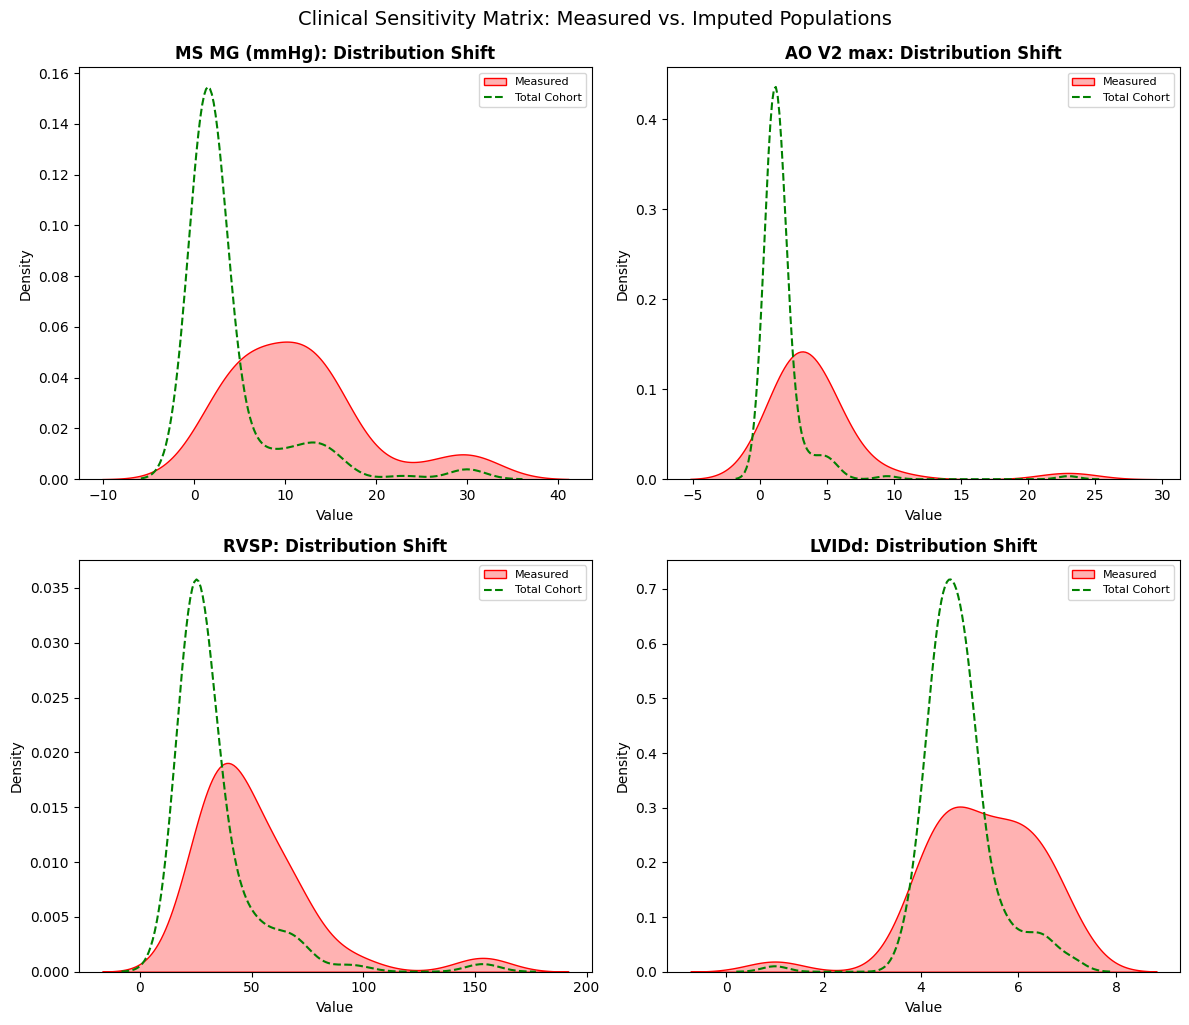

,Measured Mean,Cohort Mean,Delta (Shift),Triage Bias,Sample Size (n)
Clinical Parameter,,,,,
MS MG (mmHg),11.4,3.7,-7.6,Significant Shift,35
AO V2 max,4.3,1.7,-2.6,Significant Shift,26
RVSP,51.0,33.3,-17.7,Significant Shift,51
LVIDd,5.2,4.8,-0.5,Stable,37



Complexity frequency and stratification
----------------------------------------


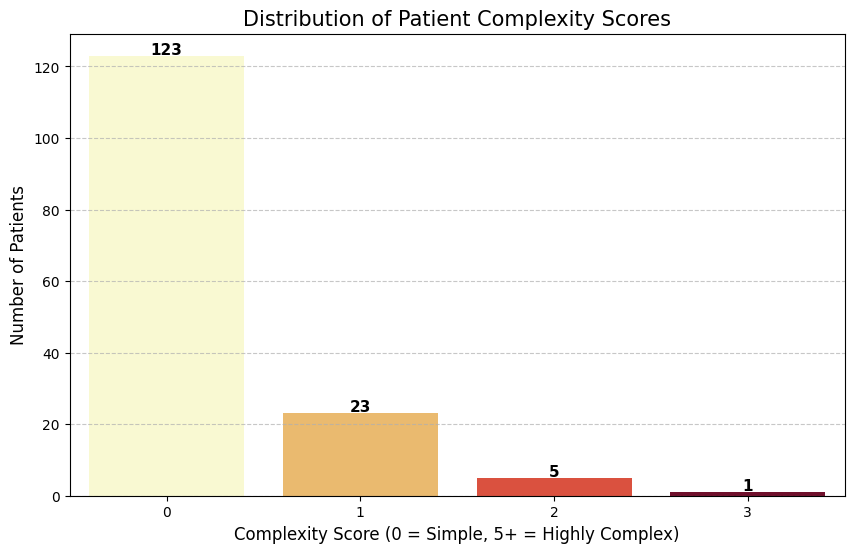

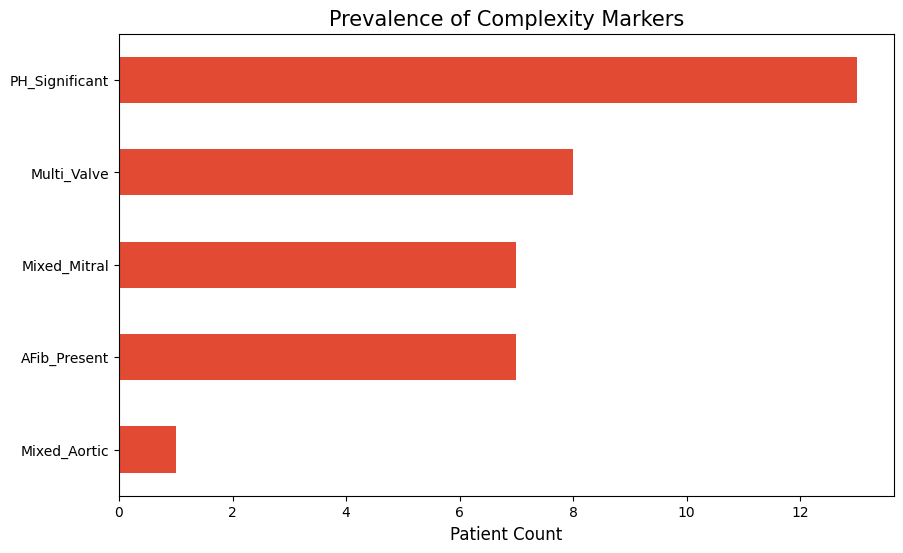

Echo parameters heatmap interaction
----------------------------------------


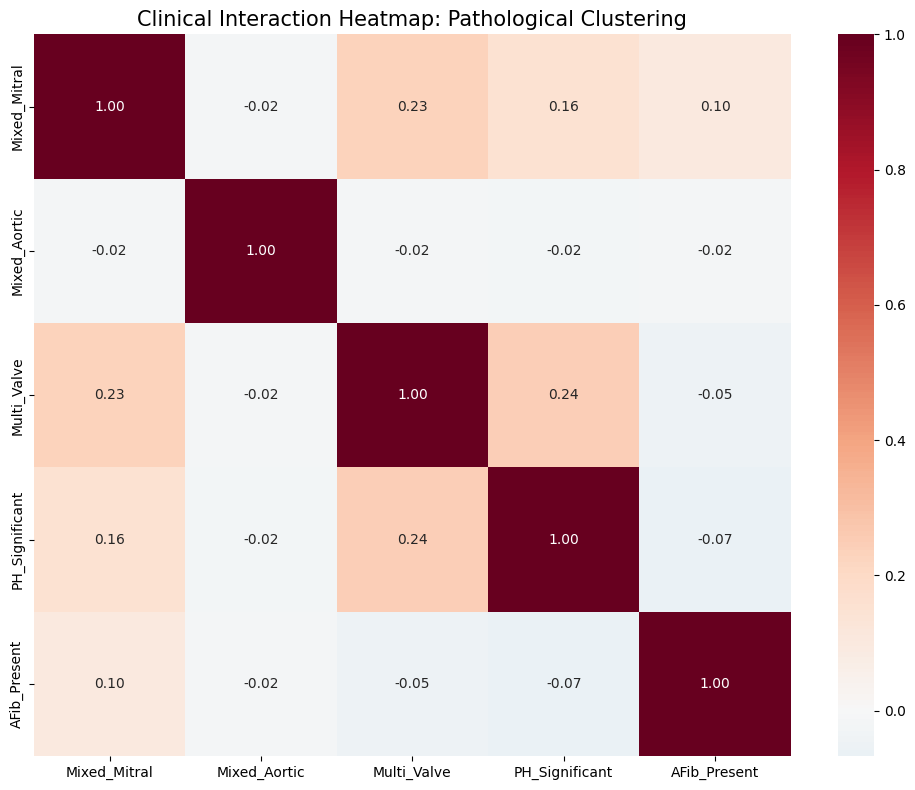

In [265]:
print(f"PHASE 4: Visualizing Mission Data\n{'='*40}")
viz = Visualizer(df, config)

# Your custom imputation comparison method
print("Sensitivity analysis for the Stochastic Imputation\n" + '-'*40)
viz.sensitivity_grid()
sensitivity_table = stats.sensitivity_report()
display(sensitivity_table)

# Complexity Analysis (Updated Markers: PH in, Shunts out)
clinical_markers = ['Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'PH_Significant', 'AFib_Present']
print("\nComplexity frequency and stratification\n" + '-'*40)
viz.complexity_frequency()
viz.complexity_markers(clinical_markers)
print("Echo parameters heatmap interaction\n" + '-'*40)
viz.complexity_heatmap(clinical_markers)

In [258]:
print(f"PHASE 5: Executive Summary\n{'='*40}")
total = len(df)
complexity = (df['Complexity_Score'] >= 1)
high_risk = complexity.mean() * 100
avg_mbi = df['MBI'].mean()

print(f"TOTAL PATIENTS:  {total}")
print(f"HIGH-RISK CASES: {high_risk:.1f}% (n={complexity.sum()})")
print(f"AVG MEDICATION BURDEN:  {avg_mbi:.2f}")

print("\nDISEASE COMPLEXITY\n" + '-'*40)
for key, value in extractor.complexity_stats.items():
    print(f"{key}:  {value}")

print(f"\nDISEASE PREVALENCE:")
print("-" * 30)
with pd.option_context('display.max_rows', None):
    print(extractor.diagnoses_prevalence())

PHASE 5: Executive Summary
TOTAL PATIENTS:  152
HIGH-RISK CASES: 19.1% (n=29)
AVG MEDICATION BURDEN:  2.86

DISEASE COMPLEXITY
----------------------------------------
Total Patients:  152
Mixed Mitral:  7
Mixed Aortic:  1
Multi-Valvular:  8
Significant PH (>=2.0):  13
AFib Present:  7

DISEASE PREVALENCE:
------------------------------
Mitral stenosis                                                 49
Aortic stenosis                                                 34
Secundum atrial septal defect                                   22
Mitral regurgitation                                            19
Pulmonary hypertension                                          15
Aortic regurgitation                                            15
Surgical aortic valve replacement                               14
Bicuspid aortic valve                                           12
Mitral valve percutaneous valvuloplasty                         11
Atrial fibrillation                                       

In [259]:
# # ==========================================
# # ROC ANALYSIS: MBI as a Predictor of Complexity
# # ==========================================

# # 1. Redefining Target: Capturing 'Rising Risk' (Score 1 or higher)
# # We use the imputed dataframe to ensure the denominator includes the whole cohort
# df_final['Is_Complex_Case'] = (df_final['Complexity_Score'] >= 1).astype(int)

# # 2. Recalculate ROC Metrics
# # We are testing how well MBI (Medication Burden) predicts Clinical Complexity
# fpr, tpr, thresholds = roc_curve(df_final['Is_Complex_Case'], df_final['MBI'])
# roc_auc = auc(fpr, tpr)

# # 3. Finding the Optimal Cutoff using Youden's J statistic
# # This identifies the point where Sensitivity and Specificity are maximized
# j_scores = tpr - fpr
# best_idx = np.argmax(j_scores)
# best_cutoff = thresholds[best_idx]

# # 4. Visualization
# plt.figure(figsize=(10, 7))
# plt.plot(fpr, tpr, color='#e34a33', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='#bdbdbd', linestyle='--', label='Random Classifier')
# plt.scatter(fpr[best_idx], tpr[best_idx], color='black', s=100, zorder=5,
#             label=f'Optimal MBI Cutoff: {best_cutoff:.2f}')

# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('True Positive Rate (Sensitivity)')
# plt.title('Predictive Power: Medication Burden vs. Clinical Complexity', fontsize=14)
# plt.legend(loc='lower right')
# plt.grid(alpha=0.3)
# plt.show()

# print(f"Analysis Complete: An MBI above {best_cutoff:.2f} is the best predictor of patient complexity.")

In [260]:
# # 5. EXPLORATIONS
# # ==========================================

# # 1. Redefining Target: Capturing 'Rising Risk' (Score 1 or higher)
# calculated['Is_Complex_Case'] = (calculated['Complexity_Score'] >= 1).astype(int)

# # 2. Recalculate ROC Metrics
# fpr, tpr, thresholds = roc_curve(calculated['Is_Complex_Case'], calculated['MBI'])
# roc_auc = auc(fpr, tpr)

# # 3. Finding the Optimal Cutoff
# j_scores = tpr - fpr
# best_idx = np.argmax(j_scores)
# best_cutoff = thresholds[best_idx]

# # 4. Visualization
# plt.figure(figsize=(10, 7))
# plt.plot(fpr, tpr, color='#e34a33', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
# plt.scatter(fpr[best_idx], tpr[best_idx], color='black', s=100, 
#             label=f'Optimal MBI Cutoff: {best_cutoff:.2f}')

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC: MBI vs. Complexity Score >= 1 (Rising Risk)', fontsize=14)
# plt.legend()
# plt.show()

# print(f"Total Complex Cases (Score >= 1): {final_df['Is_Complex_Case'].sum()} out of {len(final_df)}")

In [261]:
# plt.figure(figsize=(12, 8))

# sns.scatterplot(
#     data=calculated,
#     x='Max_Pathology_Severity',
#     y='MBI',
#     hue='Discordance_Type',
#     style='Discordance_Type',
#     palette={'Matched': 'grey', 'Explained High Burden': 'blue', 'True Discordance (TEE Priority)': 'red'},
#     s=100,
#     alpha=0.7
# )

# plt.axhline(y=5.0, color='black', linestyle='--', alpha=0.3)
# plt.title("MBI vs. Global Cardiac Severity: Identifying Unexplained Clinical Burden", fontsize=15)
# plt.xlabel("Maximum Severity Score (Any Pathology)", fontsize=12)
# plt.ylabel("Medication Burden Index (MBI)", fontsize=12)
# plt.grid(True, alpha=0.2)
# plt.show()

In [262]:
# 6. LOG OF CURRENT STATUS OF CODE
# ==========================================
file = 'phl_2025_1.ipynb'
os.system(f"jupyter nbconvert --to markdown {file}")
print(f"Success! Markdown file generated: {file.replace('.ipynb', '.md')}")


Success! Markdown file generated: phl_2025_1.md
